## NB: Start an ImageJ server before you run this!

```
git clone git://github.com/imagej/imagej-server
cd image-server
mvn -Pexec
```

In [1]:
import json
import StringIO

import imagej.server as imagej
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

In [2]:
ij = imagej.IJ()

In [3]:
# Find modules that contain a specific string in its ID.
create = ij.find('CreateImgFromImg')[0]
invert = ij.find('InvertII')[0]

In [4]:
# Check details of a module. Names of "inputs" and "outputs" are usually important.
print('Details for CreateImgFromImg:')
print(json.dumps(ij.detail(create), indent=4))

print('Details for InvertII:')
print(json.dumps(ij.detail(invert), indent=4))

Details for CreateImgFromImg:
{
    "inputs": [
        {
            "columnCount": 6, 
            "minimumValue": null, 
            "name": "in", 
            "maximumValue": null, 
            "defaultValue": null, 
            "required": true, 
            "choices": null, 
            "widgetStyle": "", 
            "stepSize": null, 
            "softMinimum": null, 
            "label": "", 
            "genericType": "net.imglib2.img.Img<capture of ?>", 
            "softMaximum": null
        }
    ], 
    "identifier": "command:net.imagej.ops.create.img.CreateImgFromImg", 
    "outputs": [
        {
            "columnCount": 6, 
            "minimumValue": null, 
            "name": "out", 
            "maximumValue": null, 
            "defaultValue": null, 
            "required": true, 
            "choices": null, 
            "widgetStyle": "", 
            "stepSize": null, 
            "softMinimum": null, 
            "label": "", 
            "genericType": "net.

In [5]:
# Upload an image.
img_in = ij.upload('data/images/cells-16bit.tif')
img_in

u'object:jf1kg92us1x6nnab'

In [6]:
# Execute modules.
result = ij.run(create, {'in': img_in})
img_out = result['out']

result = ij.run(invert, {'in': img_in, 'out': img_out})
img_out = result['out']

In [7]:
# Retrieve images.
cells_png = ij.retrieve(img_out, format='png')

In [8]:
def data2image(data):
    return Image.open(StringIO.StringIO(data))

def show(image):
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()

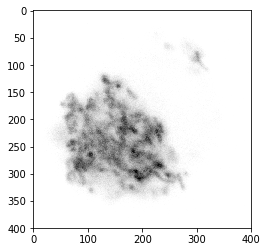

In [9]:
# convert image data to PIL image.
cells_pil = data2image(cells_png)

# We can also convert a PIL image to numpy array as needed.
cells_np = np.array(cells_pil)
show(cells_np)